## Joint Optimization Results

In [1]:
import torch
import torch.nn as nn
import time
import sys
import nibabel as nib
import os

sys.path.append('/home/agajan/DeepMRI')
from deepmri import Datasets, utils  # noqa: E402
from DiffusionMRI.ConvEncoder import ConvEncoder  # noqa: E402
from DiffusionMRI.ConvDecoder import ConvDecoder  # noqa: E402
from deepmri.RNNEncoder import RNNEncoder  # noqa: E402
from deepmri.RNNDecoder import RNNDecoder  # noqa: E402
from deepmri.Conv3DRNNCell import Conv3DGRUCell  # noqa: E402

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# pytorch settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True  # set False whenever input size varies

Device:  cuda:0


In [3]:
# data settings
batch_size = 1
data_path = '/media/schultz/345de007-c698-4c33-93c1-3964b99c5df6/agajan/experiment_DiffusionMRI/'

In [4]:
print("Loading data...")
st = time.time()
data = nib.load(os.path.join(data_path, 'data/one_data/data_151526.nii.gz')).get_data()
seq_len = 10
data = data.transpose(3, 0, 1, 2)  # time x width x height x depth
data = torch.tensor(data).float()[0:seq_len]
data = data.unsqueeze(1).unsqueeze(0)  # batch x time x channel x width x height x depth

mu = data.mean()
std = data.std()
print("Minval: {}, Maxval: {}, Mean: {}, Std: {}".format(data.min(), data.max(), mu, std))

trainloader = [data]
trainset = [data]
print("Loaded data in {:.5f} seconds: ".format(time.time() - st))

Loading data...
Minval: 0.0, Maxval: 33099.4609375, Mean: 340.2902526855469, Std: 838.5985717773438
Loaded data in 22.50475 seconds: 


In [5]:
# model settings
conv_encoder = ConvEncoder(input_channels=1)
conv_decoder = ConvDecoder(out_channels=1)

rnn_encoder = RNNEncoder(
    Conv3DGRUCell,
    input_channels=64,
    hidden_channels=64,
    kernel_size=3,
    stride=1,
    padding=1,
    hidden_kernel_size=3
)

rnn_decoder = RNNDecoder(
    Conv3DGRUCell,
    input_channels=64,
    hidden_channels=64,
    kernel_size=3,
    stride=1,
    padding=1,
    hidden_kernel_size=3,
    output_channels=64,
    output_kernel_size=3
)

# send models to device
conv_encoder.to(device)
conv_decoder.to(device)
rnn_encoder.to(device)
rnn_decoder.to(device)

# load pretrained weights
epoch = 30000
print("Loading weights after training for {} epochs".format(epoch))
conv_encoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/overfit_joint_conv_encoder_epoch_' + str(epoch)
conv_decoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/overfit_joint_conv_decoder_epoch_' + str(epoch)
conv_encoder.load_state_dict(torch.load(conv_encoder_path))
conv_decoder.load_state_dict(torch.load(conv_decoder_path))

rnn_encoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/overfit_joint_rnn_encoder_epoch_' + str(epoch)
rnn_decoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/overfit_joint_rnn_decoder_epoch_' + str(epoch)
rnn_encoder.load_state_dict(torch.load(rnn_encoder_path))
rnn_decoder.load_state_dict(torch.load(rnn_decoder_path))

# count parameters
p1 = utils.count_model_parameters(conv_encoder)
p2 = utils.count_model_parameters(conv_decoder)
p3 = utils.count_model_parameters(rnn_encoder)
p4 = utils.count_model_parameters(rnn_decoder)
print("Total trainable parameters: {}".format(p1[0] + p2[0] + p3[0] + p4[0]))

Loading weights after training for 30000 epochs
Total trainable parameters: 2130914


In [6]:
# evaluate
conv_encoder.eval()
conv_decoder.eval()
rnn_encoder.eval()
rnn_decoder.eval()

ConvLoss = nn.MSELoss()
RNNLoss = nn.MSELoss()

conv_recons = []
rnn_features = []

with torch.no_grad():
    running_loss = 0.0
    epoch_start = time.time()
    
    for data in trainloader:
        # pass 3D volume through ConvAE
        conv_loss = torch.tensor([0.], requires_grad=True, device=device)
        features = []
        fshape = None

        for t in range(data.size(1)):
            x = data[:, t, :, :, :, :].to(device)
            x = (x - mu) / std
            feature = conv_encoder(data[:, t, :, :, :, :].to(device))
            fshape = feature.shape
            x_out = conv_decoder(feature)
            
            # keep this reconstruction for visualization
            conv_recons.append((x_out * std + mu).clamp(min=0).cpu())
            
            conv_loss = conv_loss + ConvLoss(x, x_out)
            features.append(feature.unsqueeze(0))  # channel x w x h x d

        # create src_batch from features
        src_batch = torch.zeros(1, seq_len, fshape[1], fshape[2], fshape[3], fshape[4])
        for t in range(seq_len):
            src_batch[:, t, :, :, :, :] = features[t]

        # -------------------Seq2Seq Start------------------ #
        src_batch = src_batch.to(device)

        context_batch = rnn_encoder(src_batch)

        hidden_batch = context_batch

        # first input is <sos> in learning phrase representation
        # in this case it is tensor of zeros
        input_batch = src_batch.new_zeros(src_batch[:, 0, :, :, :, :].shape)

        rnn_loss = src_batch.new_zeros(1)
        for t in range(seq_len):
            input_batch, hidden_batch = rnn_decoder(input_batch, hidden_batch, context_batch)
            rnn_features.append(input_batch)
            rnn_loss = rnn_loss + RNNLoss(src_batch[:, t, :, :, :, :], input_batch)

        rnn_loss = rnn_loss / seq_len
        # -------------------Seq2Seq End------------------- #

        combined_loss = conv_loss + rnn_loss
        running_loss = running_loss + combined_loss.item()

    epoch_loss = running_loss / len(trainset)
    print("Combined loss: {}, inference time: {:.5f} seconds".format(epoch_loss, time.time() - epoch_start))

# reconstruct from rnn features
rnn_recons = []
with torch.no_grad():
    for rnn_feature in rnn_features:
        rnn_recon = conv_decoder(rnn_feature)
        rnn_recons.append((rnn_recon * std + mu).clamp(min=0).cpu())

Combined loss: 1.0170609951019287, inference time: 0.63183 seconds


## Visualize Reconstruction from Learned Features

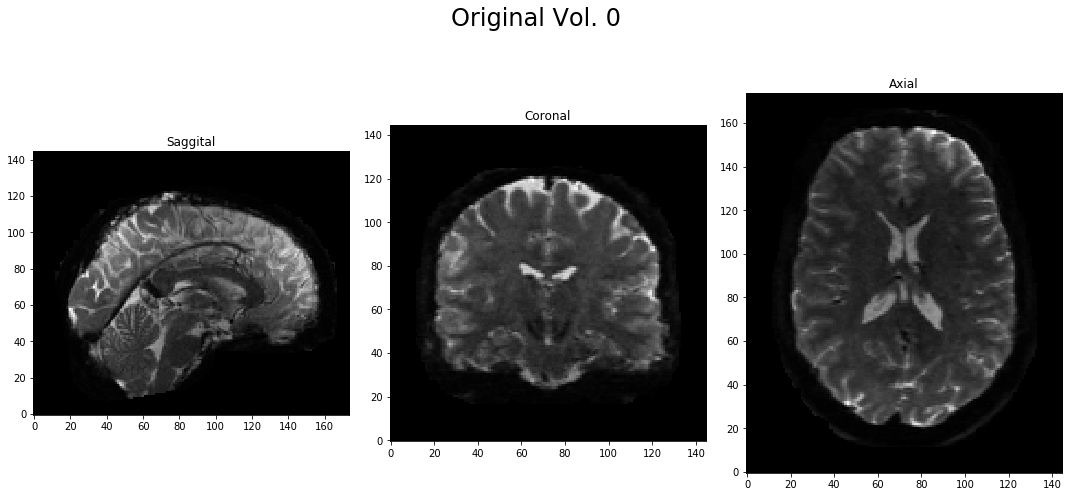

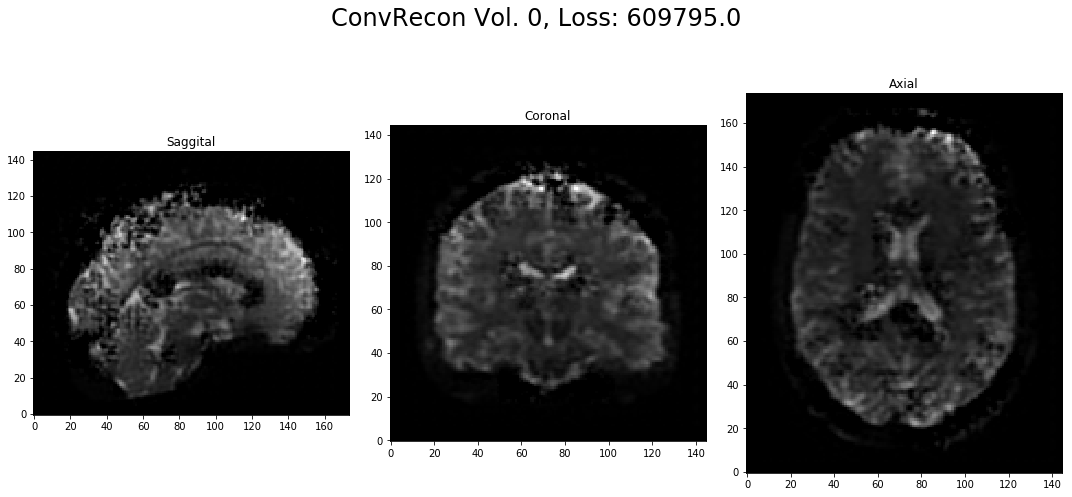

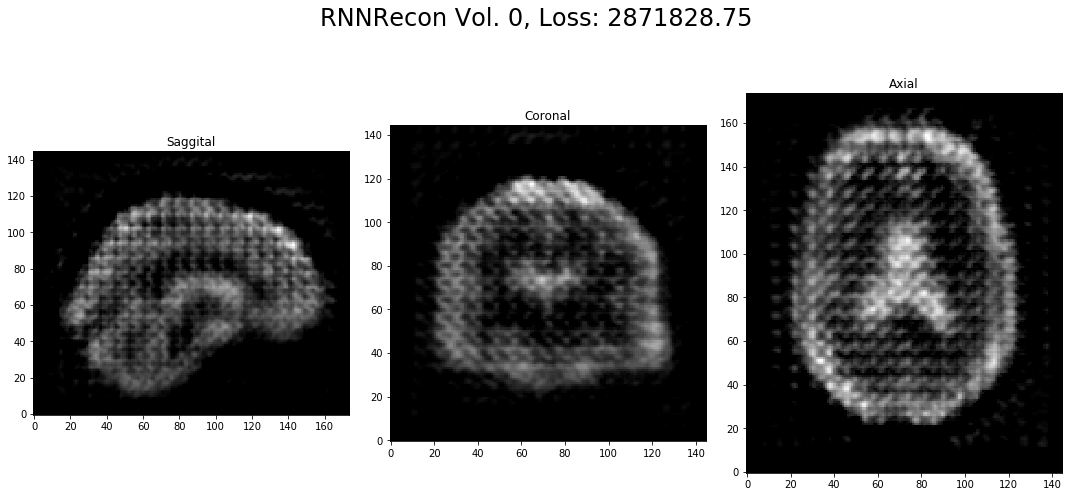

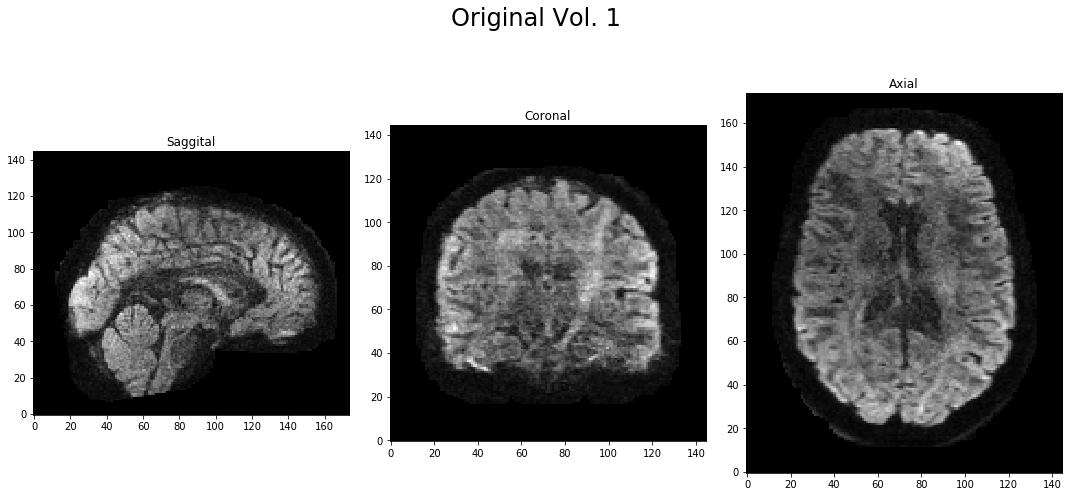

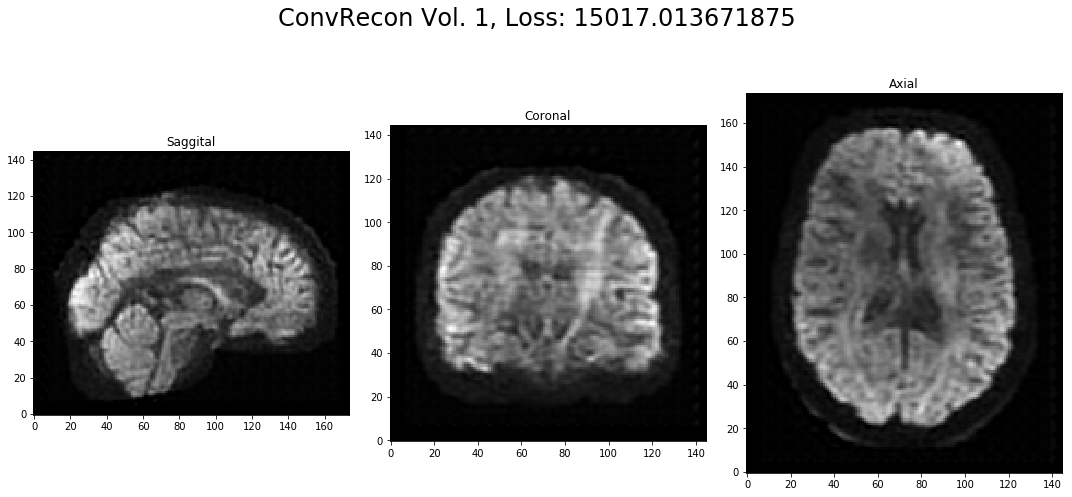

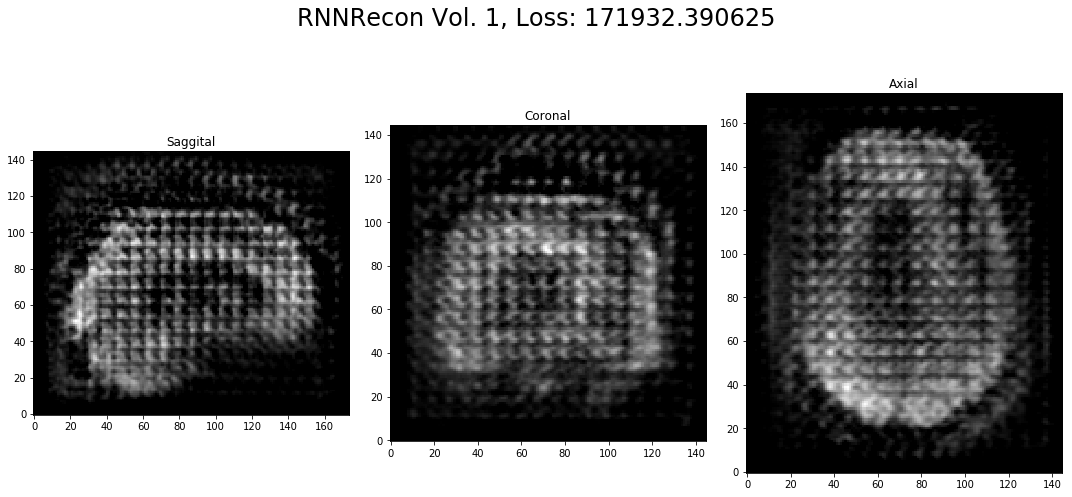

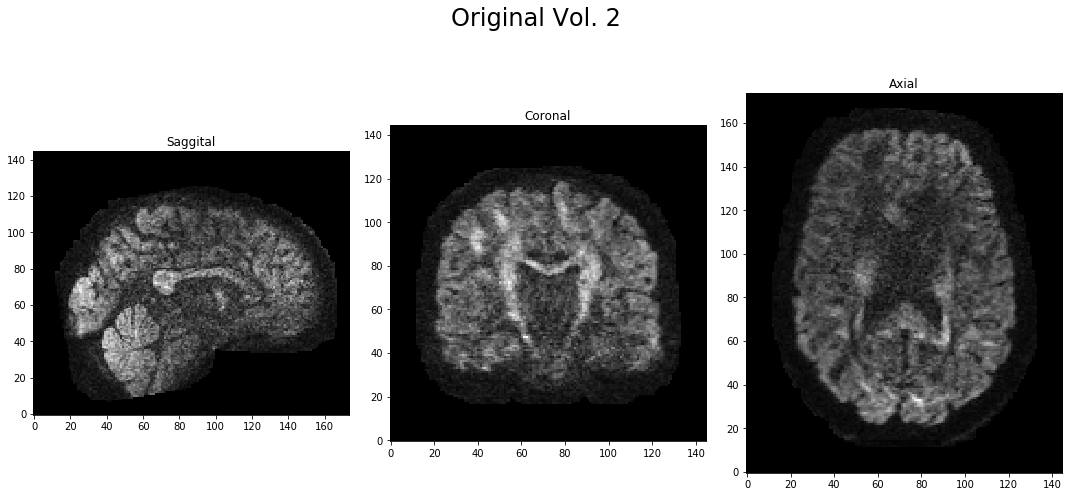

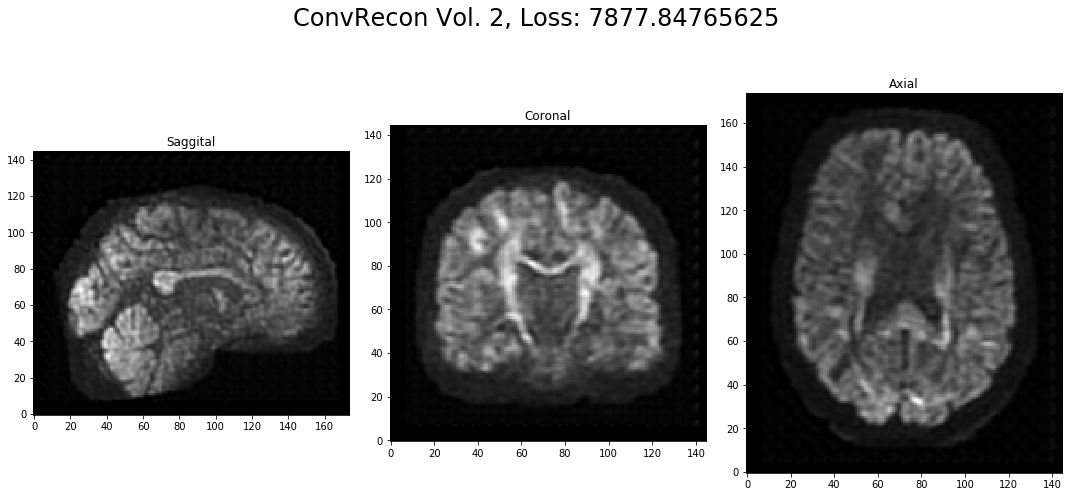

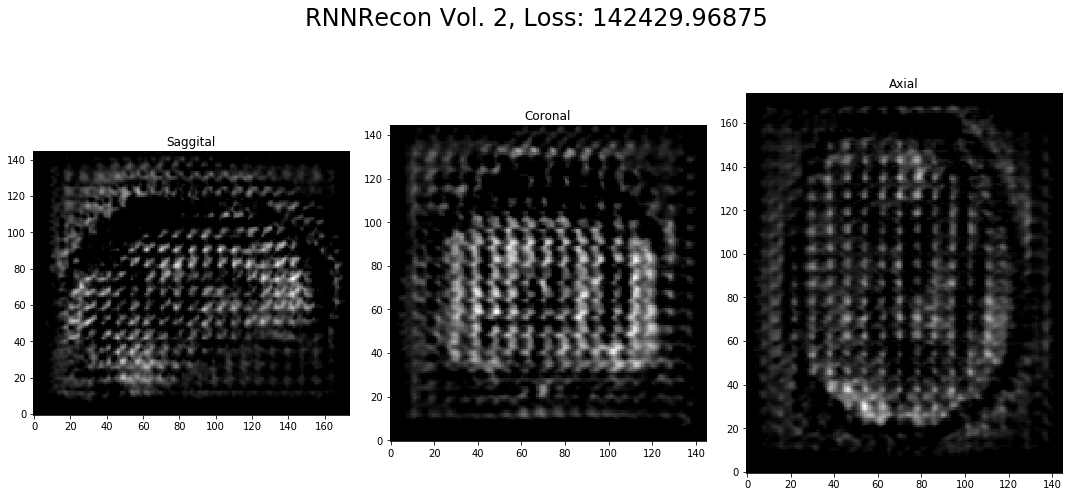

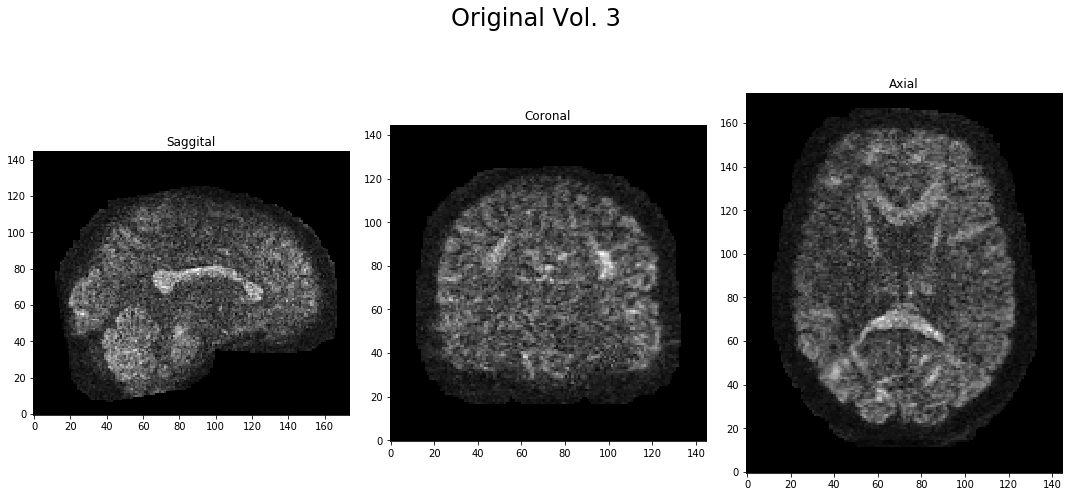

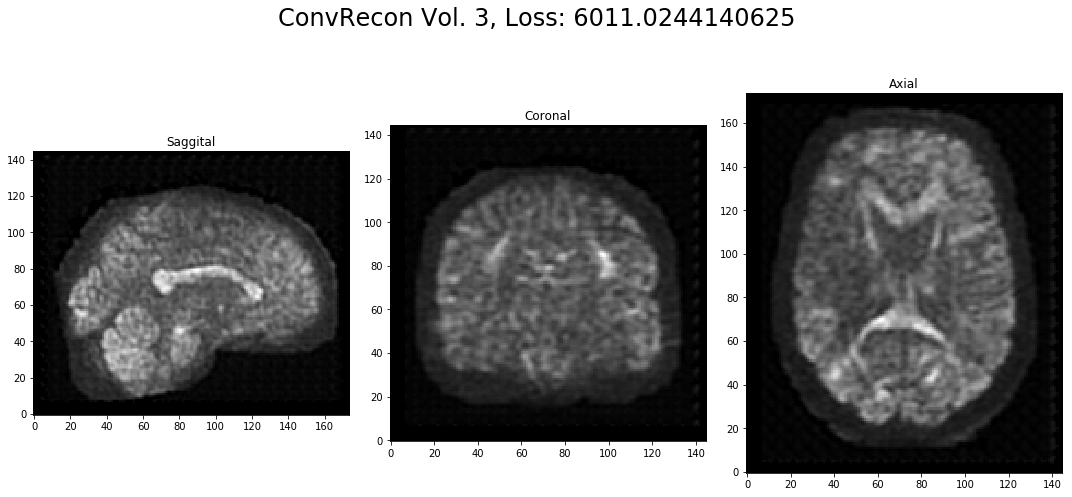

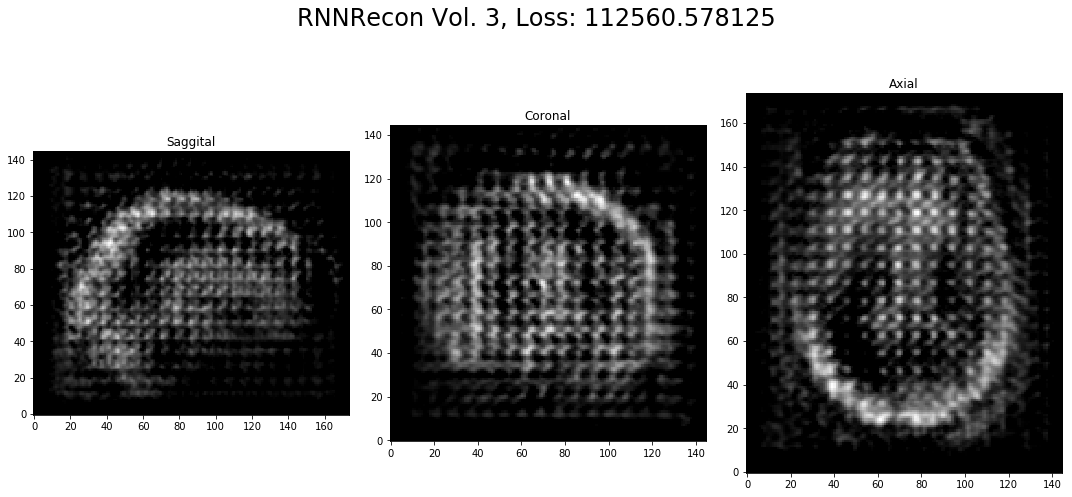

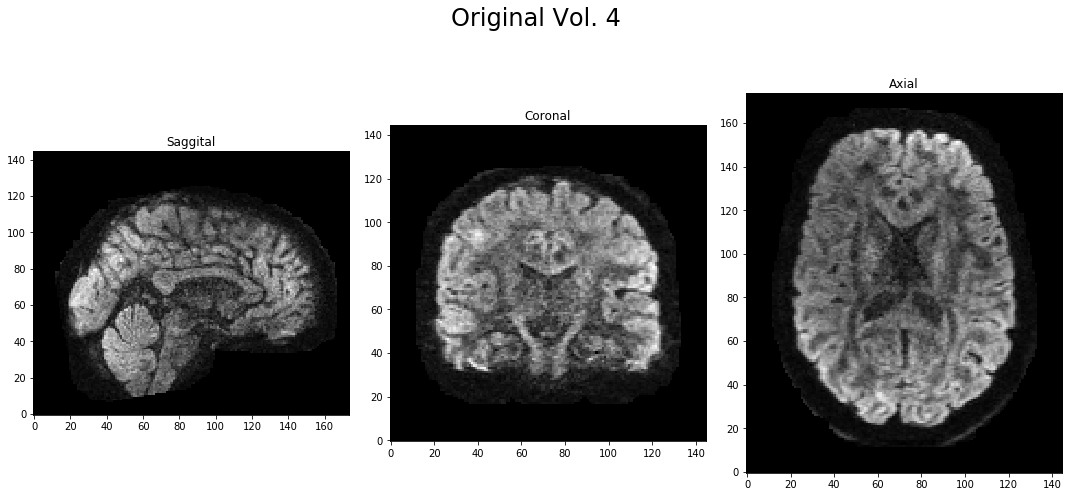

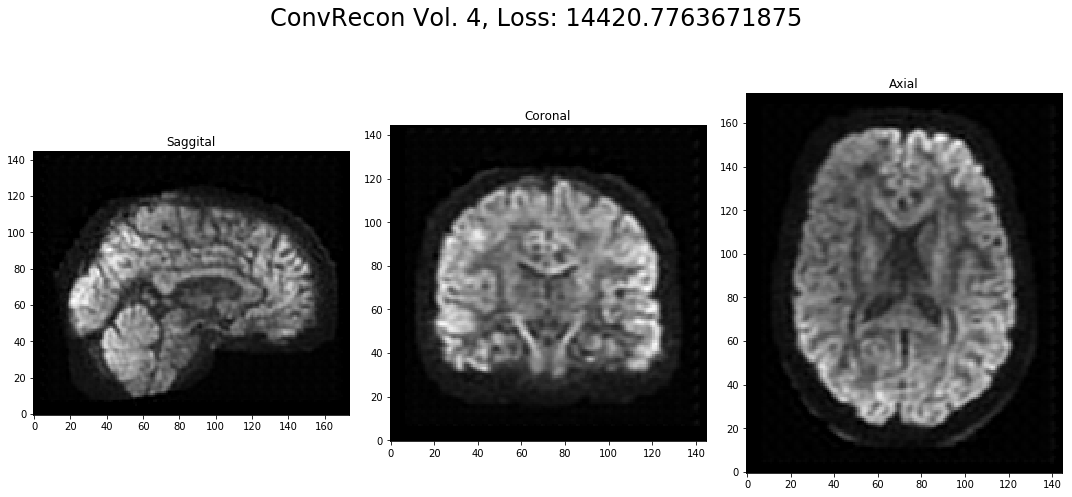

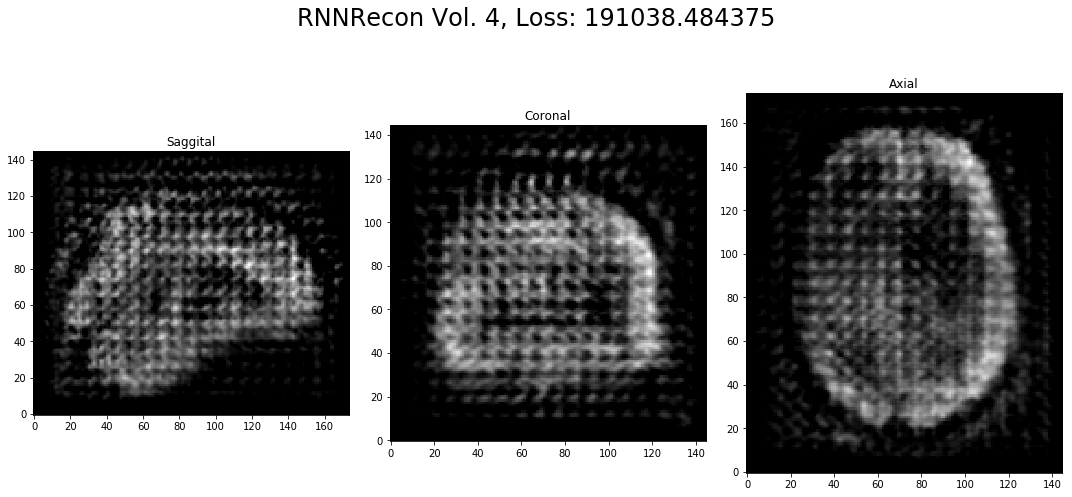

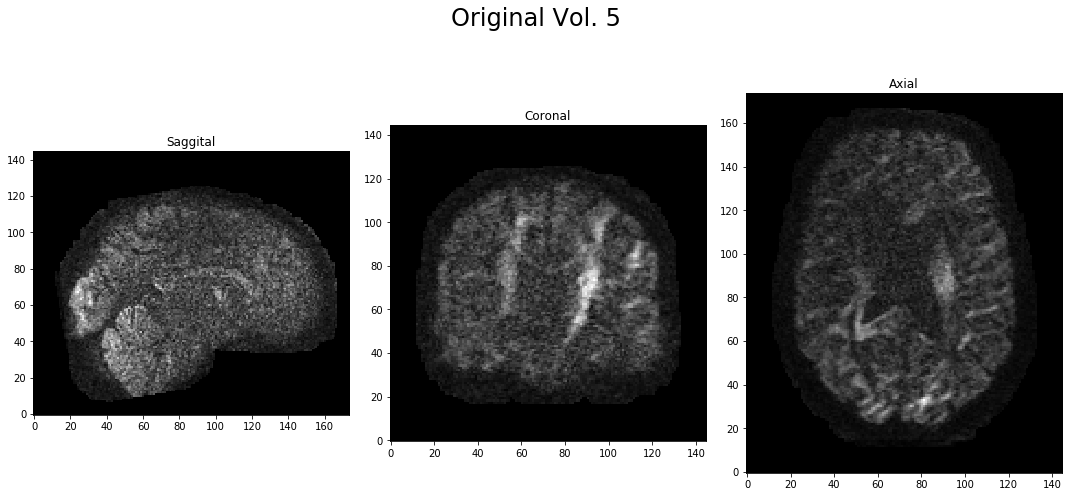

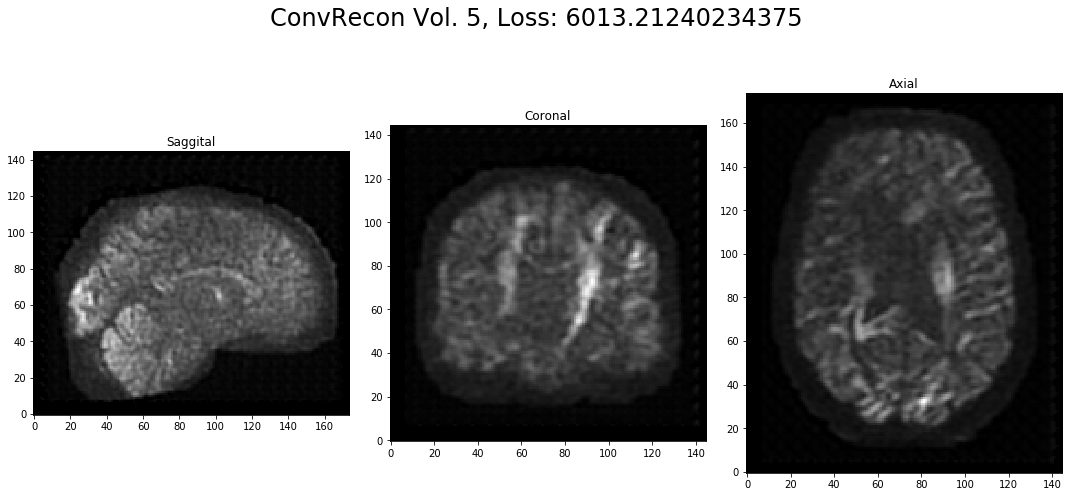

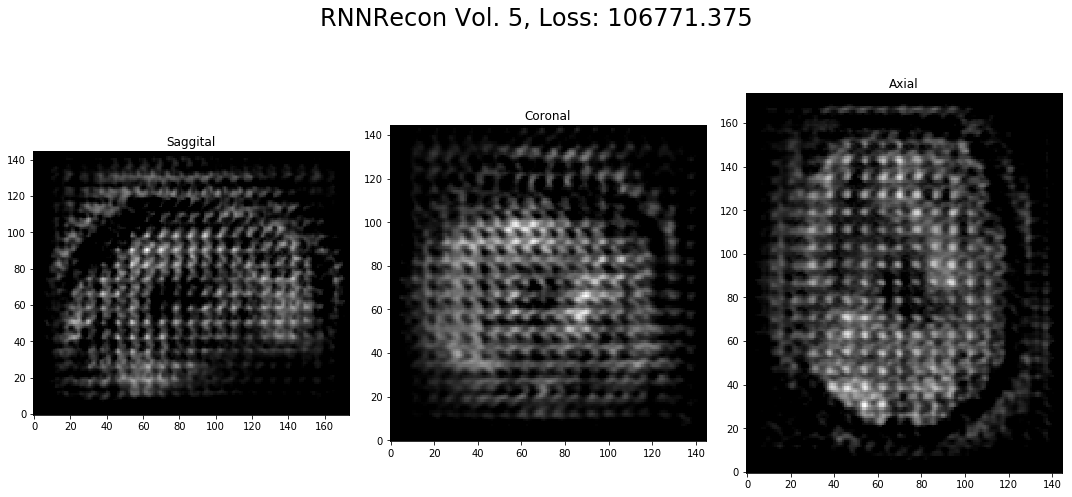

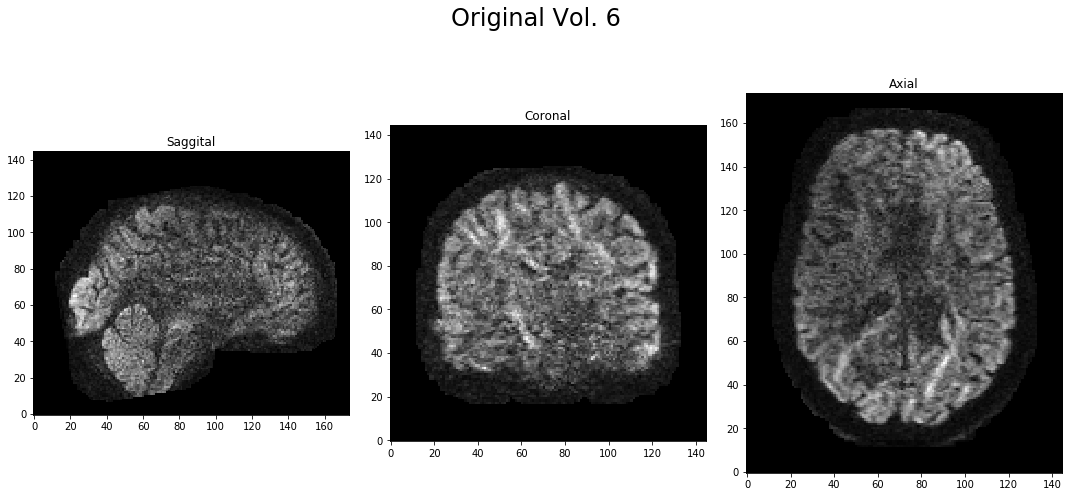

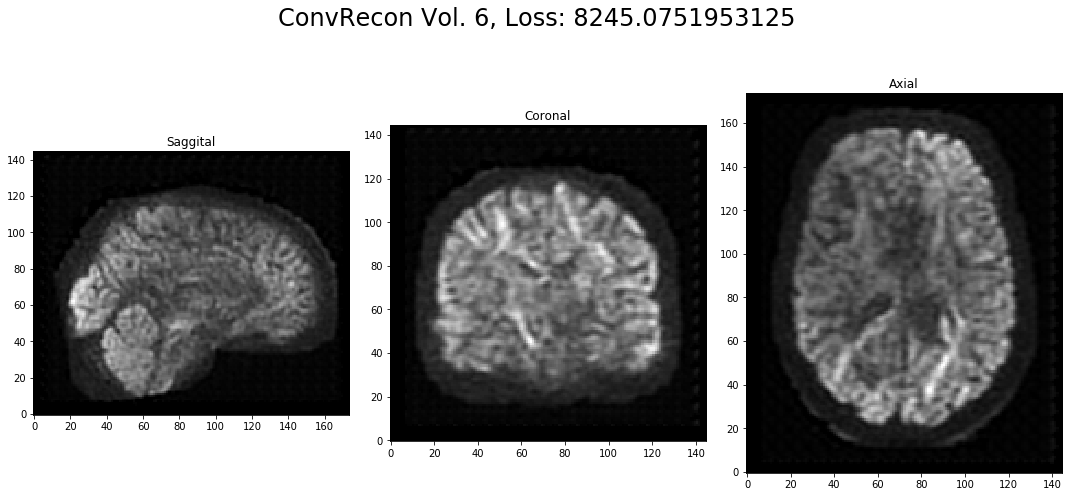

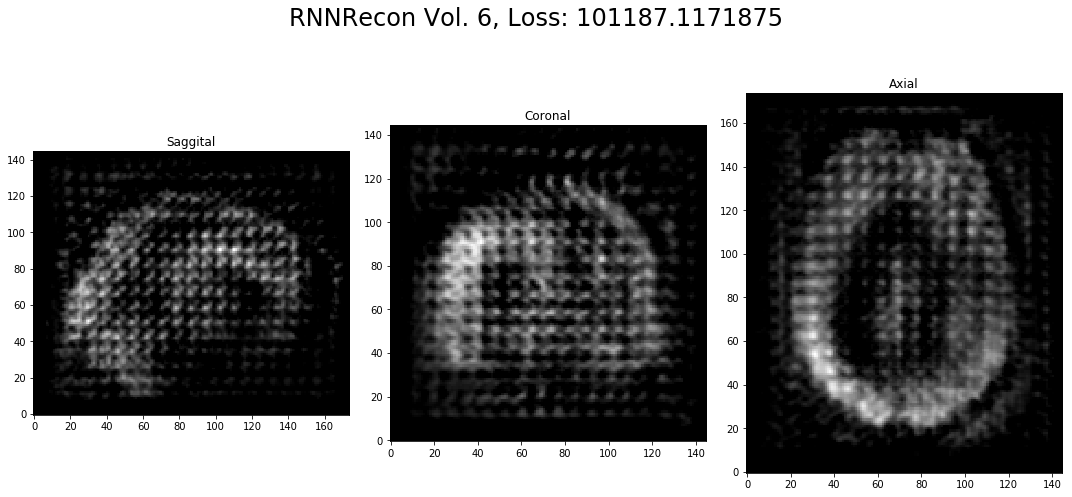

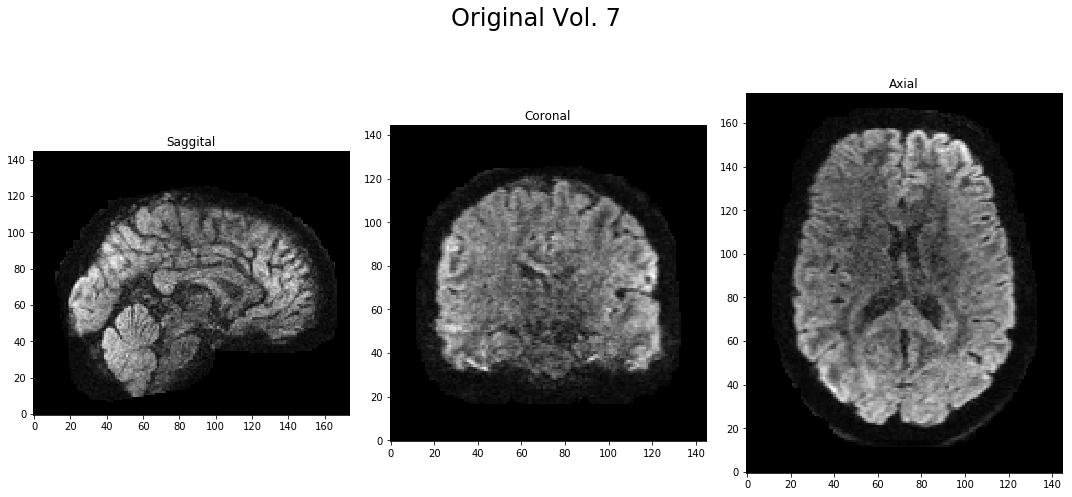

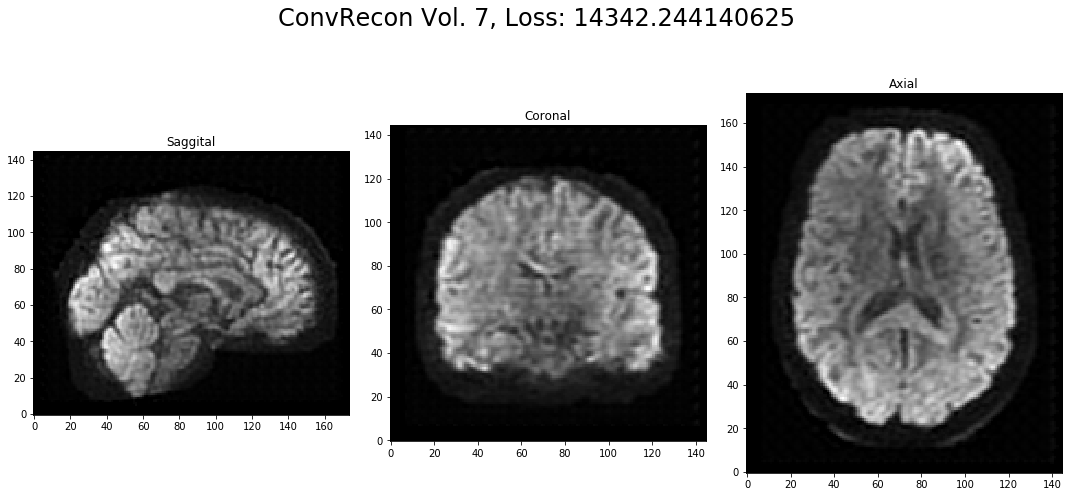

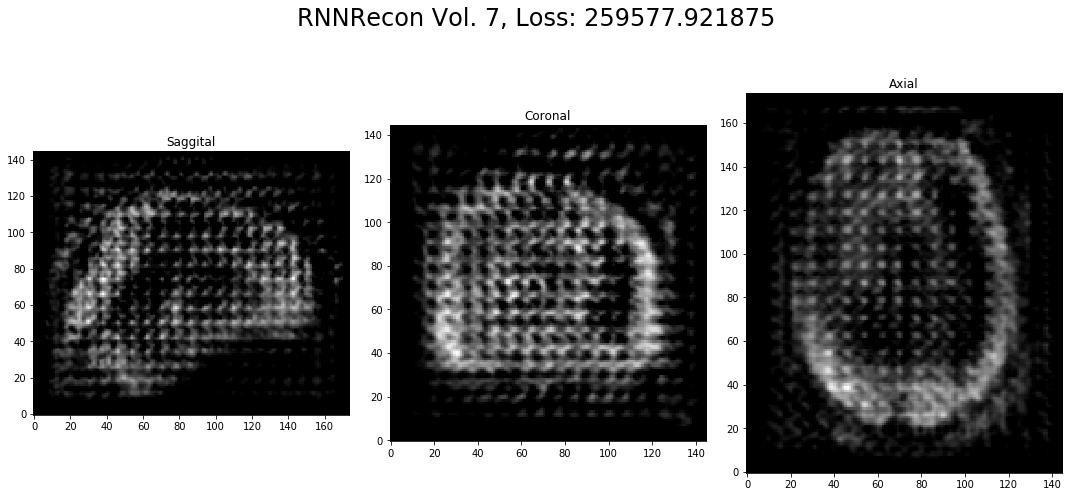

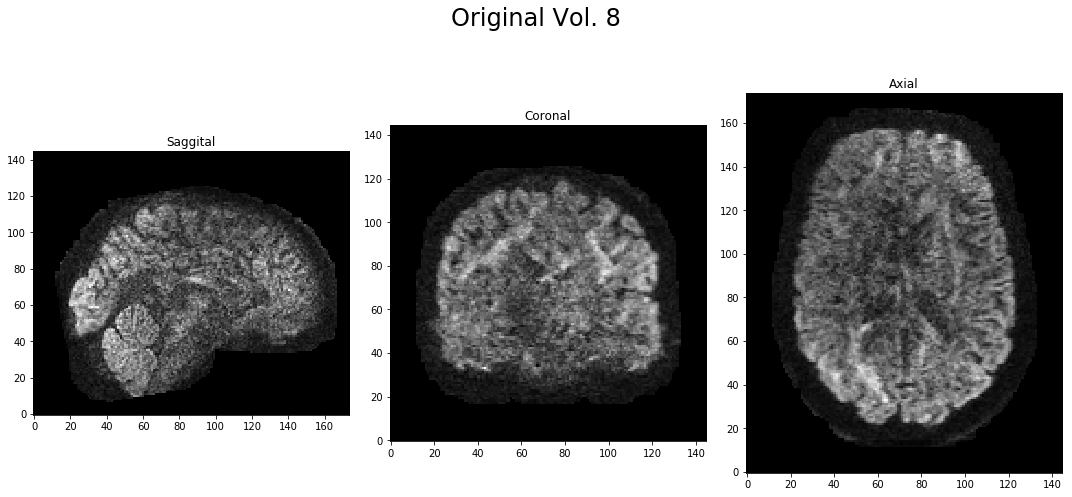

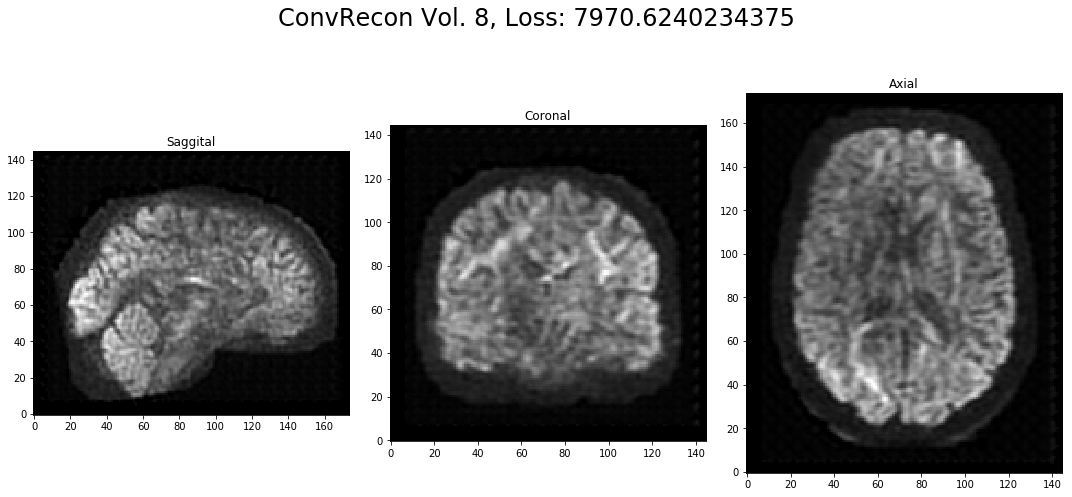

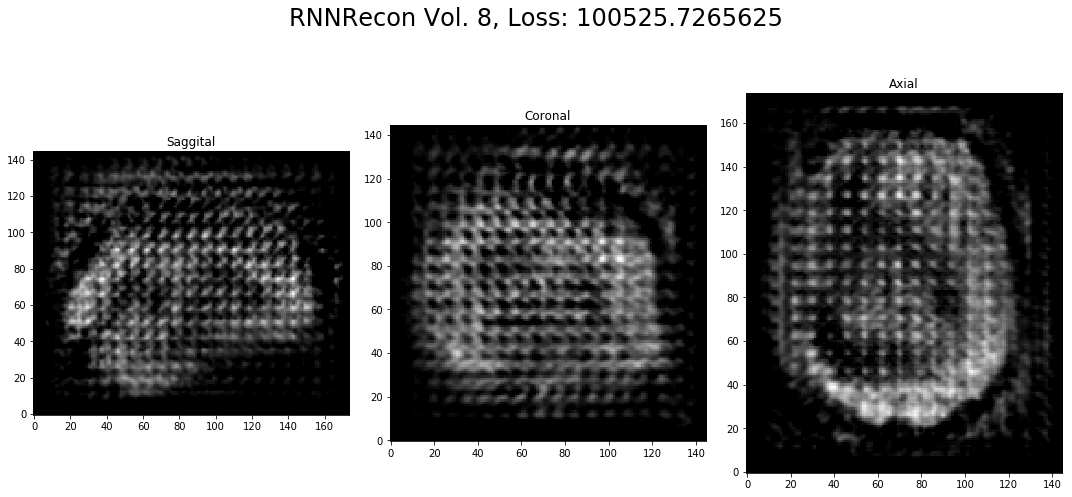

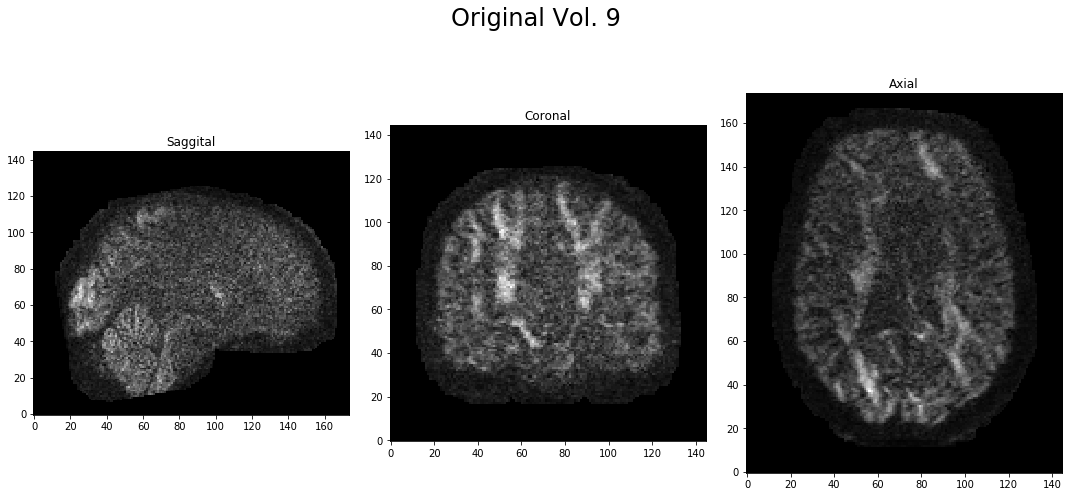

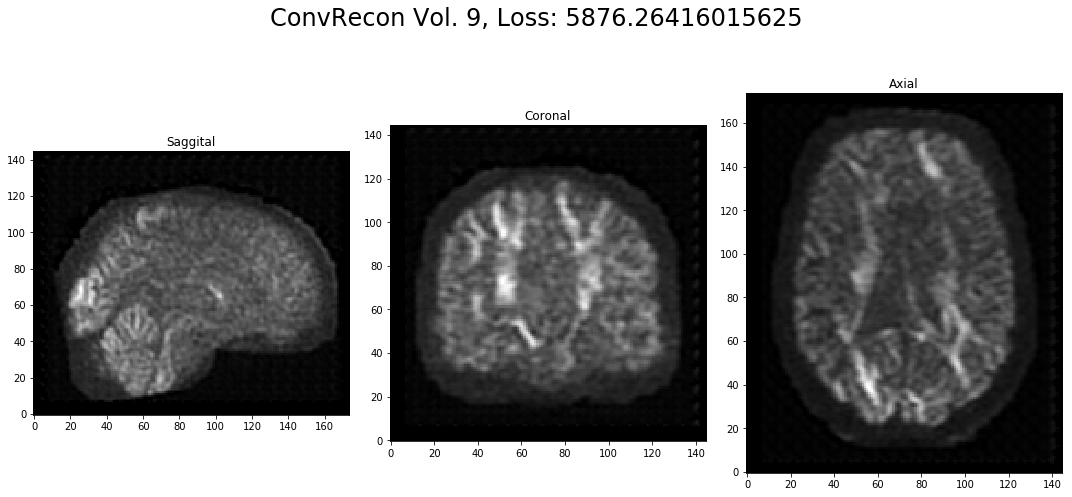

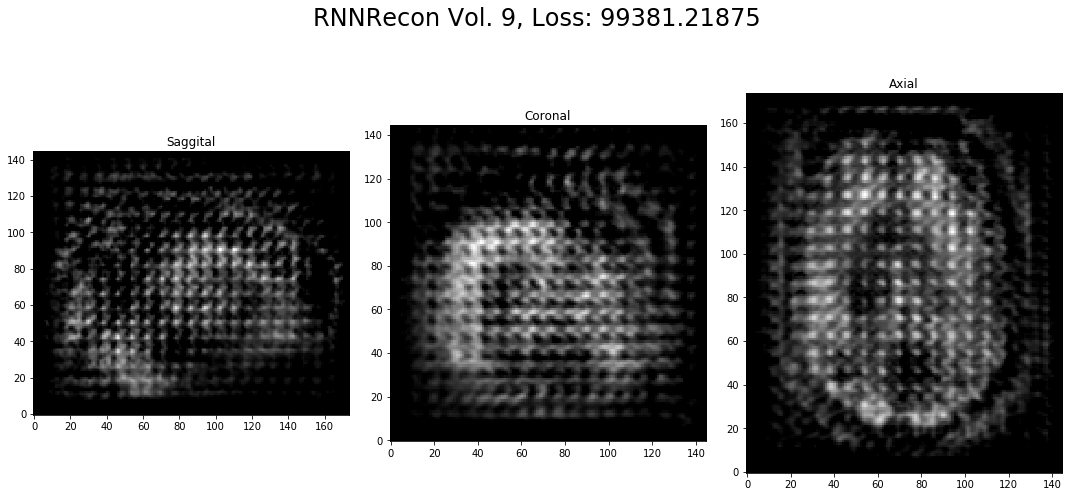

In [7]:
x_coord = 72
y_coord = 87
z_coord = 72

criterion = nn.MSELoss()

for vol_idx in range(seq_len):
    orig = data.squeeze()[vol_idx]
    conv_recon = conv_recons[vol_idx].squeeze()
    rnn_recon = rnn_recons[vol_idx].squeeze()
    
    conv_vol_loss = criterion(orig, conv_recon).item()
    rnn_vol_loss = criterion(orig, rnn_recon).item()
    
    utils.show_slices([
        orig[x_coord, :, :].numpy(),
        orig[:, y_coord, :].numpy(),
        orig[:, :, z_coord].numpy(),
    ], figsize=(15, 8), suptitle="Original Vol. {}".format(vol_idx))
    
    utils.show_slices([
        conv_recon[x_coord, :, :].numpy(),
        conv_recon[:, y_coord, :].numpy(),
        conv_recon[:, :, z_coord].numpy(),
    ], figsize=(15, 8), suptitle="ConvRecon Vol. {}, Loss: {}".format(vol_idx, conv_vol_loss))
    
    utils.show_slices([
        rnn_recon[x_coord, :, :].numpy(),
        rnn_recon[:, y_coord, :].numpy(),
        rnn_recon[:, :, z_coord].numpy(),
    ], figsize=(15, 8), suptitle="RNNRecon Vol. {}, Loss: {}".format(vol_idx, rnn_vol_loss))